## Task 3 — Data Augmentation and Feature Engineering (30 points)

> First Practice: Time‑Warp Data Augmentation (Probabilistic Compression/Stretching)

- Creates additional copies of ECG signals *for the training set only* by randomly compressing or stretching their duration, enhancing robustness to heart rate variations.
- **Trajectory:**
   - Load `X_orig`, `y_orig`.
   - **Split:** First, perform a **stratified** train/validation split on `(X_orig, y_orig)` to separate original signals cleanly (`train_orig_idx`, `val_orig_idx`).
   - **Train Augmentation:** Apply `time_compress_stretch` with rates `[0.8, 0.9, 1.1, 1.2]` *only* to training set originals (`X_orig[train_orig_idx]`), creating `X_train_aug`.
   - **Combine Training Data:** Concatenate original training signals (`X_train_orig`) with `X_train_aug` to form `X_train_all`, duplicating `y_train_orig` for `y_train_all`.
   - **Validation Set:** `X_val`, `y_val` consist *only* of original validation signals (`X_orig[val_orig_idx]`).

- Reasoning
   - **Avoids Data Leakage:** Augmenting *after* splitting prevents validation set contamination.
   - **Heart Rate Robustness:** Simulates physiological variations (faster/slower rhythms).
   - **Increased Diversity:** Expands training data with varied synthetic signals.
   - **Label Preservation:** Time-warping doesn't alter arrhythmia class.
---
> Second Practice: Gaussian Noise Augmentation

- Adds random Gaussian noise to ECG signals *during training* to improve robustness to real-world sensor noise and imperfections.
- **Trajectory:**
   - **On-the-fly:** `prep_batch_noisy` (as `collate_fn` for `train_loader`) dynamically adds noise to each batch.
   - **Validation Purity:** `val_loader` uses `prep_batch` (no noise) for unbiased evaluation.
   - **Noise Control:** `noise_std` parameter (e.g., `0.01`) tunes noise intensity.

- Reasoning
   - **Simulates Noise:** Mimics real-world ECG recording interference.
   - **Model Robustness:** Helps learn features from slightly corrupted signals, reducing overfitting.
   - **Dynamic Diversity:** Different noise patterns per epoch for the same signal.
   - **Validation Integrity:** Ensures accurate performance assessment on clean data.
---
> Third Practice: Hand Crafted Statistical Features

--- 
> Fourth Practice: Time Shifting

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
from scipy.interpolate import interp1d

def time_compress_stretch(signal, rate=0.8):
    """
    Applies time compression or stretching to a 1D time series signal.

    This technique, often referred to as time stretching/compression or time warping,
    simulates natural variations in the speed or duration of events within a time series.
    By altering the temporal dimension, it helps the model become more robust to the
    precise "sampling" or timing of the signal, enhancing its invariance to time deformation.[1]

    Args:
        signal (np.ndarray): The input 1D time series signal.
        rate (float): The compression rate. A rate < 1.0 compresses the signal
                      (makes it shorter/faster), while a rate > 1.0 stretches it
                      (makes it longer/slower). Default is 0.8 for compression.

    Returns:
        np.ndarray: The time-compressed signal.
    """
    original_length = len(signal)
    new_length = int(original_length * rate)

    # Create original time points (indices)
    original_time_points = np.arange(original_length)

    # Create new time points for the compressed signal
    # These points will span the original signal's "time" but with a new number of steps
    new_time_points = np.linspace(0, original_length - 1, new_length)

    # Create an interpolation function based on the original signal
    # 'linear' interpolation is a common and simple choice for time series.
    interpolator = interp1d(original_time_points, signal, kind='linear', fill_value="extrapolate")

    # Apply the interpolation to the new time points
    compressed_signal = interpolator(new_time_points)

    return compressed_signal

In [3]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from src.parser import read_zip_binary
from src.train import train_model
from src.ecg_dataset import ECGDataset, prep_batch, prep_batch_noisy_shifting, ECGTestDataset, prep_test_batch
from src.stft_baseline import BaselineSTFTModel
from src.stft_featured import BaselineSTFTFeaturedModel
from sklearn.utils.class_weight import compute_class_weight
from src.split import create_stratified_split

X_orig = read_zip_binary("../data/X_train.zip")     #list of 1D numpy arrays
y_orig = pd.read_csv("../data/y_train.csv", header=None, names=["y"])


# Perform the stratified split on the original data first
# This ensures a clean separation of original signals into train and validation sets
train_orig_idx, val_orig_idx = create_stratified_split(X_orig, y_orig, val_size=0.2, seed=343)

# Prepare the training data: Original training signals + Augmented training signals
X_train_orig = [X_orig[i] for i in train_orig_idx]
y_train_orig = y_orig.iloc[train_orig_idx]

# Apply time compression/stretching only to the original training signals
rates = [0.8, 0.9, 1.1, 1.2]
X_train_aug = [time_compress_stretch(s, rate=np.random.choice(rates)) for s in X_train_orig]

# Concatenate original training signals with augmented training signals
X_train_all = X_train_orig + X_train_aug
y_train_all = pd.concat([y_train_orig, y_train_orig], ignore_index=True) # Labels for augmented data

# Prepare the validation data: Only the original validation signals
X_val = [X_orig[i] for i in val_orig_idx]
y_val = y_orig.iloc[val_orig_idx]


# Build datasets & loaders
train_dataset = ECGDataset(X_train_all, y_train_all) # X_train_all already contains original + augmented
val_dataset   = ECGDataset(X_val, y_val)             # X_val contains only original validation data

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn=prep_batch_noisy_shifting) # Use noisy for training
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, collate_fn=prep_batch)       # Keep clean for validation (no noise, no time stretch)

device = "cpu"

#model = BaselineSTFTModel().to(device)
model = BaselineSTFTFeaturedModel().to(device)

weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1, 2, 3]), y=y_train_all["y"]) # Use y_train_all for weights
weights = torch.tensor(weights, dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=5e-4,
    weight_decay=1e-4 # L2 regularization
)

model, history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=50)

Unique predictions: (array([0, 1, 2, 3]), array([388, 190, 622,  36]))
Epoch 01 | Time: 59.5s
  Train Loss: 1.8334 | Acc: 0.2580 | F1: 0.2065
  Val   Loss: 1.6983 | Acc: 0.3519 | F1: 0.2300
Unique predictions: (array([0, 1, 2, 3]), array([311, 176, 723,  26]))
Epoch 02 | Time: 58.6s
  Train Loss: 1.7071 | Acc: 0.2780 | F1: 0.2180
  Val   Loss: 1.6137 | Acc: 0.3414 | F1: 0.2223
Unique predictions: (array([0, 1, 2, 3]), array([298, 255, 680,   3]))
Epoch 03 | Time: 57.2s
  Train Loss: 1.6003 | Acc: 0.2931 | F1: 0.2243
  Val   Loss: 1.5136 | Acc: 0.3301 | F1: 0.2220
Unique predictions: (array([0, 1, 2, 3]), array([637, 441, 150,   8]))
Epoch 04 | Time: 56.2s
  Train Loss: 1.4967 | Acc: 0.2820 | F1: 0.2194
  Val   Loss: 1.3914 | Acc: 0.4070 | F1: 0.2509
Unique predictions: (array([0, 1, 2, 3]), array([680, 112, 193, 251]))
Epoch 05 | Time: 56.8s
  Train Loss: 1.3180 | Acc: 0.3478 | F1: 0.2875
  Val   Loss: 1.1330 | Acc: 0.4879 | F1: 0.3646
Unique predictions: (array([0, 1, 2, 3]), array([6

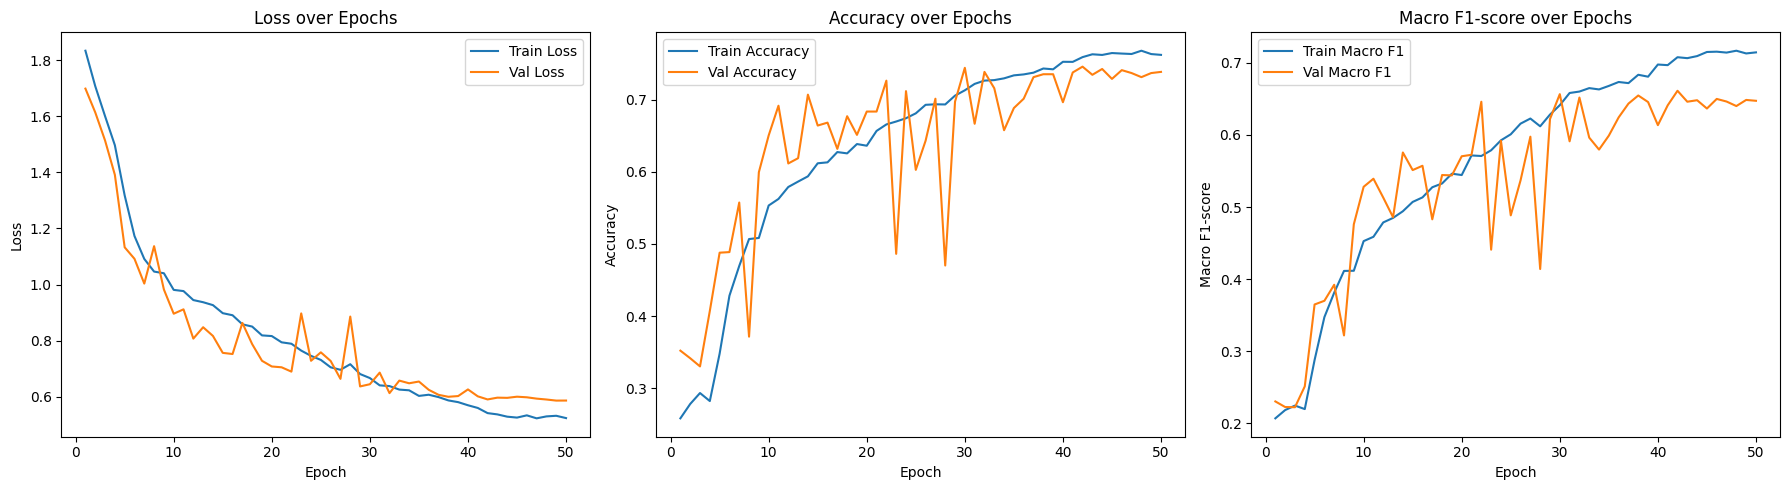

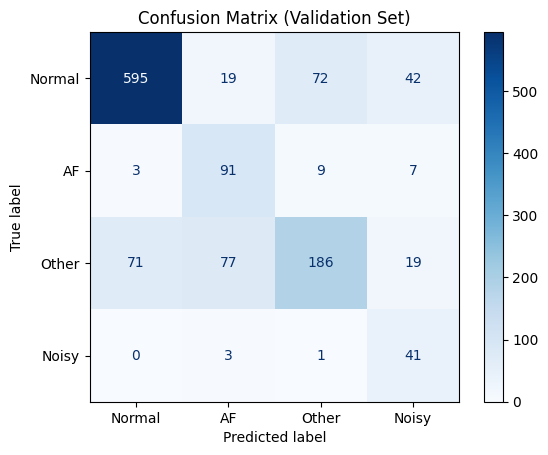

In [4]:
# Performance Measure Visualizations

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Training History Visualization

def plot_training_history(history):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    # Macro F1
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_f1"], label="Train Macro F1")
    plt.plot(epochs, history["val_f1"], label="Val Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1-score")
    plt.title("Macro F1-score over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Confusion Matrix Visualization on Validation Set

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for signals, labels, lengths in dataloader:
            signals = [s.to(device) for s in signals]
            labels = labels.to(device)
            outputs = model(signals, lengths)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix (Validation Set)")
    plt.show()


class_names = ["Normal", "AF", "Other", "Noisy"]
plot_confusion_matrix(model, val_loader, device, class_names)


In [ ]:
X_test = read_zip_binary("../data/X_test.zip")
test_dataset = ECGTestDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=prep_test_batch)

model.eval()    # using model that is in the memory -- inference mode

# inference
# store every prediction into predictions list
predictions = []
with torch.no_grad():
    for signals, lengths in test_loader:
        signals = [s.to(device) for s in signals]
        outputs = model(signals, lengths)
        preds = outputs.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())

# save to csv file
pd.DataFrame(predictions).to_csv("../csvs/augment.csv", index=False, header=False)